#Project: Deepfake Detection using Deep Learning
Student Name: Hari Sri Rama Sai Karthik Paluri


In [1]:
# 1. Install dependencies
# !pip install facenet-pytorch kagglehub

###Import all required Libraries

In [2]:
import os
import glob
import time
import shutil
import random
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm.auto import tqdm

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Face Detection
from facenet_pytorch import MTCNN
import kagglehub

In [3]:
# Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on: {DEVICE}")

Running on: cuda


CUDA-enabled GPU is used if available; otherwise, it  runs on CPU.

##Task 1 - The Data

In [4]:
# Download Dataset from kaggle
root_dir = kagglehub.dataset_download("jayanthbottu/labeled-deepfake-image-collection")

Using Colab cache for faster access to the 'labeled-deepfake-image-collection' dataset.


###About Dataset:
  - Contains a total of 10 folders and **18,124 RGB images** of human faces
  - Collection of both authentic ("Real") and synthetically generated images.
  - The synthetic images are categorized into subfolders based on the specific AI models used to create them, such as Midjourney, Stable Diffusion, and DALL-E, among others.
  - **Total 10 classes:** 'DALL-E', 'NeuralTextures', 'Real', 'Stable Diffusion', 'Midjourney', 'FaceShifter', 'DeepFaceLab', 'Face2Face', 'FaceSwap', 'StyleGAN'
  - A mix of **.jpg** and **.png** format files.

### Dataset Suitability

- Instead of a binary real vs fake, the dataset consists of **10 classes**, including **1 real class and 9 fake classes generated using different methods**.
- This diversity helps prevent the model from overfitting to artifacts from any single generation technique.

In [5]:
# Build the DataFrame
data_registry = []
class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
print(f"Classes: {class_names}")

for name in class_names:
    folder_path = os.path.join(root_dir, name)
    # Check all files in the folder
    for img_path in glob.glob(os.path.join(folder_path, '*')):
        ext = os.path.splitext(img_path)[1].lower()
        data_registry.append({
            'path': img_path,
            'label': name,
            'format': ext
        })

raw_data = pd.DataFrame(data_registry)

Classes: ['DALL-E', 'DeepFaceLab', 'Face2Face', 'FaceShifter', 'FaceSwap', 'Midjourney', 'NeuralTextures', 'Real', 'Stable Diffusion', 'StyleGAN']


Instead of loading all images into memory at once, we create a Data Registry.
- This wouldn't crash the RAM.
- This allows us to easily filter data, shuffle the dataset.
- perform stratified train-test splits later without moving physical files.

In [6]:
#first 5 rows of the raw_data
raw_data.head()

,path,label,format
0,/kaggle/input/labeled-deepfake-image-collectio...,DALL-E,.jpg
1,/kaggle/input/labeled-deepfake-image-collectio...,DALL-E,.jpg
2,/kaggle/input/labeled-deepfake-image-collectio...,DALL-E,.jpg
3,/kaggle/input/labeled-deepfake-image-collectio...,DALL-E,.jpg
4,/kaggle/input/labeled-deepfake-image-collectio...,DALL-E,.jpg


##Task 2 - Initial Data Analysis

Before feeding data into a Neural Network, it is crucial to go thorough initial data analysis and preprocess if any required.

In [7]:
#Basic info of raw_data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18124 entries, 0 to 18123
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18124 non-null  object
 1   label   18124 non-null  object
 2   format  18124 non-null  object
dtypes: object(3)
memory usage: 424.9+ KB


All images are register correctly into df.


Loaded 18124 images across 10 classes.


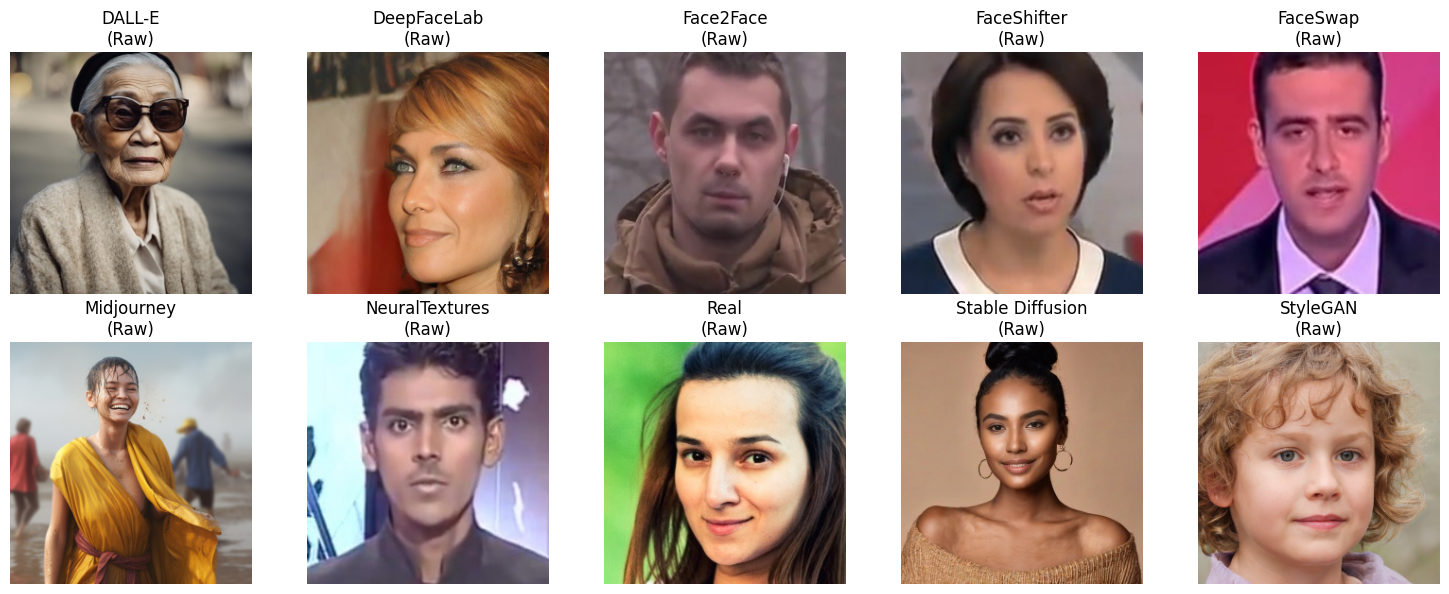

In [8]:
# Visual Sampling
print(f"Loaded {len(raw_data)} images across {len(class_names)} classes.")
sample_paths = {}

plt.figure(figsize=(15, 6))
for i, name in enumerate(class_names):
    subset = raw_data[raw_data['label'] == name]
    if len(subset) == 0: continue

    # Pick a random sample
    sample = subset.sample(1).iloc[0]
    sample_paths[name] = sample['path']

    img = cv2.imread(sample['path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"{name}\n(Raw)")
    plt.axis('off')
plt.tight_layout()
plt.show()

Issues Observed:
- Background Artefacts: Some images exhibits subtle anomalies in the background.
- Irregular Rotations: Several images apper to be arbitrarily rotated. Neural Networks are sensitive to rotation.

In [9]:
raw_data.describe()

,path,label,format
count,18124,18124,18124
unique,18124,10,2
top,/kaggle/input/labeled-deepfake-image-collectio...,Real,.jpg
freq,1,5890,14632


In [10]:
##class distribution
raw_data['label'].value_counts()

,count
label,
Real,5890
Stable Diffusion,2098
DALL-E,2000
DeepFaceLab,1606
FaceSwap,1600
Face2Face,1000
NeuralTextures,1000
FaceShifter,1000
StyleGAN,1000


- The dataset is class imbalance.
- It heavily skewed towards the "Real" class.

## Task 3 - Preprocessing

In [11]:
DEST_DIR = 'processed_dataset_final'
IMG_SIZE = 224
MIN_FACE_RES = 64

# Helper function to align face based on eyes
def align_face(img, left_eye, right_eye):
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = math.degrees(math.atan2(dy, dx))
    center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    return img.rotate(angle, center=center, resample=Image.BICUBIC)


# Initialize MTCNN
mtcnn = MTCNN(image_size=IMG_SIZE,
              margin=20,
              min_face_size=40,
              select_largest=True,
              post_process=False,
              device=DEVICE
              )

# Check if we need to run processing
for cls in class_names:
    os.makedirs(os.path.join(DEST_DIR, cls), exist_ok=True)

processed_registry = []

for index, row in tqdm(raw_data.iterrows(), total=len(raw_data), desc="Processing"):
    cls = row['label']
    save_path = os.path.join(DEST_DIR, cls, f"{index}.jpg")

    try:
        img = Image.open(row['path']).convert('RGB')
        # Detect landmarks for alignment
        boxes, probs, points = mtcnn.detect(img, landmarks=True)

        if boxes is not None:
            # Quality Control: Resolution Check
            box = boxes[0]
            if (box[2]-box[0]) < MIN_FACE_RES or (box[3]-box[1]) < MIN_FACE_RES:
                continue # Skip low res

            # Alignment
            landmarks = points[0]
            img_aligned = align_face(img, landmarks[0], landmarks[1])

            # Crop & Save
            mtcnn(img_aligned, save_path=save_path)

            processed_registry.append({'path': save_path, 'label': cls})
    except:
        pass

data = pd.DataFrame(processed_registry)

Processing:   0%|          | 0/18124 [00:00<?, ?it/s]

### The Preprocessing Logic:
- Geometric Alignment (align_face):
  - We mathematically align the face so the eyes are perfectly horizontal.

  - Calculated the coordinates of the both eyes (dy-left, dx-right) and using arctangent function, we find the exact angle of tilt

  - The image is then rotated to make the face upright.

  - By feeding it "straight" faces, the model doesn't have to waste brainpower learning that a tilted head is still a head.

- Face Detection(MTCNN):
  - MTCNN (Multi-Task Cascaded Convolutional Networks) algorithm is one such technology that has revolutionized the field of face detection and recognition.

  - We intialize the MTCNN detector with specific contraints:
    - *image_size=224* : The target output size for our CNN.
    - *margin=20* : We add 20 pixels of padding around the chin/forehead. This ensures we capture the facial outline and hairline, which are often distorted in deepfakes.
    - *select_largest=True* : If an image has multiple people, we only take the main subject.

- Quality Control:
  - Deleted faces that are smaller than 64 x 64 pixels.
  - Low resolution faces may lack the fine texture details need to detect deepfakes.

##Task 4 - Exploratory Data Analysis

#### Aspect 1: Preprocessed Data Visual Sampling

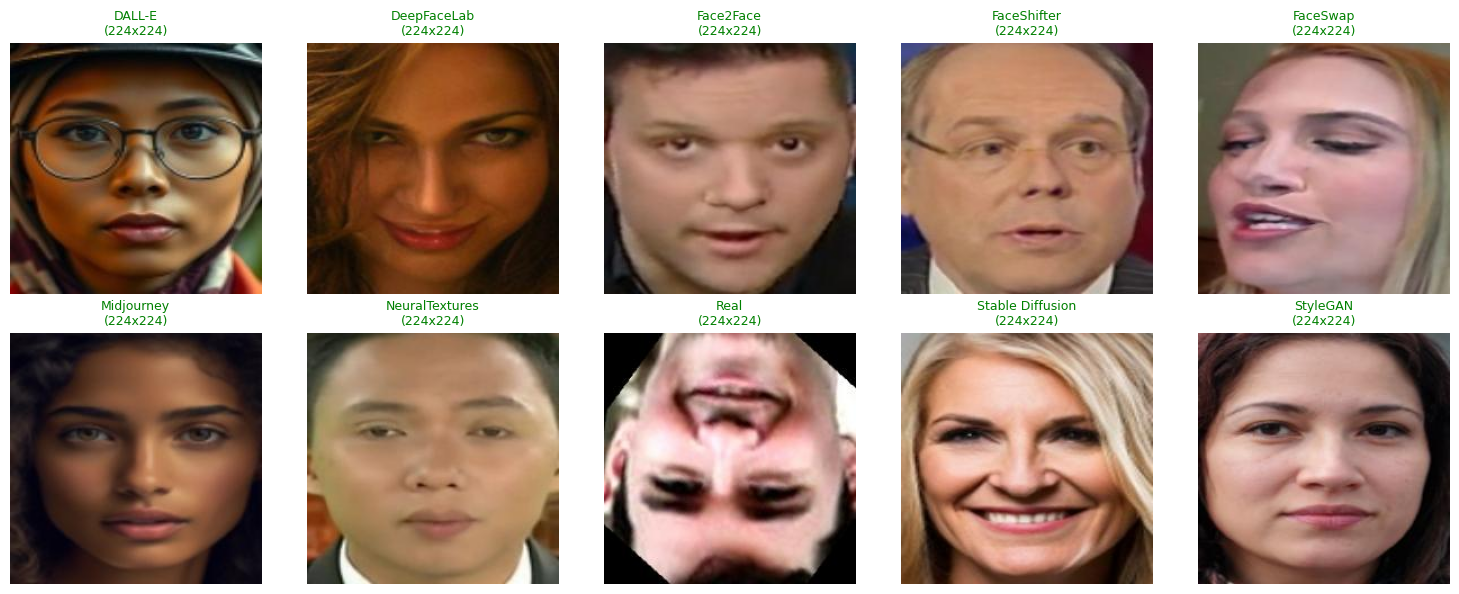

In [12]:
processed_samples = {}

# 1. Collect one image per class from the PROCESSED folder
for cls in class_names:
    cls_dir = os.path.join(DEST_DIR, cls)
    if os.path.exists(cls_dir):
        files = os.listdir(cls_dir)
        if len(files) > 0:
            # Pick a random file to check quality
            rand_file = random.choice(files)
            processed_samples[cls] = os.path.join(cls_dir, rand_file)

# 2. Plot them
plt.figure(figsize=(15, 6))

for i, (label, path) in enumerate(processed_samples.items()):
    # Load the PROCESSED image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot
    plt.subplot(2, 5, i+1)
    plt.imshow(img)

    h, w, c = img.shape
    plt.title(f"{label}\n({w}x{h})", fontsize=9, color='green')
    plt.axis('off')

plt.tight_layout()
plt.show()

We plot these samples to verify:
- Dimensions: Confirms all images are strictly **224x224**.
- Alignment: ensure faces are tightly cropped, upright and centered without unwanted background noise.


####Aspect 2: Class Imbalance Analysis

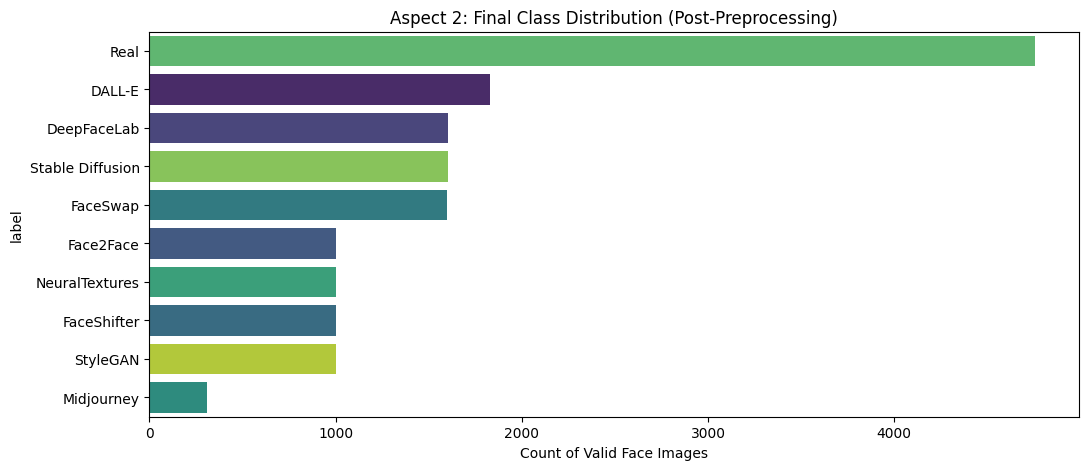

- 'Real' (Dominant): 4757 images
- 'Midjourney' (Minority): 308 images
- Imbalance Ratio: 1:15.4


In [13]:
plt.figure(figsize=(12, 5))
sns.countplot(y=data['label'], order=data['label'].value_counts().index, hue = data['label'], palette='viridis')
plt.title('Aspect 2: Final Class Distribution (Post-Preprocessing)')
plt.xlabel('Count of Valid Face Images')
plt.show()

# Calculate the exact imbalance ratio
count_real = len(data[data['label'] == 'Real'])
count_mid = len(data[data['label'] == 'Midjourney'])

print(f"- 'Real' (Dominant): {count_real} images")
print(f"- 'Midjourney' (Minority): {count_mid} images")
print(f"- Imbalance Ratio: 1:{count_real/count_mid:.1f}")

- The Imbalance ratio becomes even worse.
- Let's fix this with Cost-Sensitive Learning (Weight Loss) in the further steps.


#### Aspect 3:  Pixel Intensity Analysis (Real vs. Fake)

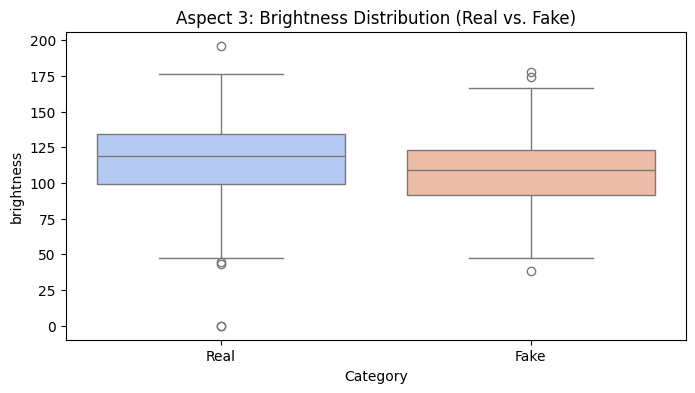

In [14]:
# Helper to get brightness
def get_brightness(path):
    img = cv2.imread(path)
    if img is None: return 0
    return img.mean()

# Sample 500 images for speed (instead of processing all 18k)
eda_sample = data.sample(min(500, len(data)), random_state=42).copy()
eda_sample['brightness'] = eda_sample['path'].apply(get_brightness)
eda_sample['Category'] = eda_sample['label'].apply(lambda x: 'Real' if x == 'Real' else 'Fake')

plt.figure(figsize=(8, 4))
sns.boxplot(x='Category', y='brightness', hue='Category', data=eda_sample, palette='coolwarm')
plt.title('Aspect 3: Brightness Distribution (Real vs. Fake)')
plt.show()


- The box plot tells that the Median plxel Intensity for both the 'Real' and 'Fake' classes is almost same.
- It means our model cannot "cheat" by just looking at how bright an image is.
- It forces the neural network to learn the hard stuff (eyes, skin texture, artifacts).

##Task 5 - Evaluation and Baseline

In [15]:
# Helper to evaluate the model
def evaluate_model(y_true, y_pred, model_name="Model"):
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print(f"\n Evaluation: {model_name}")
    print(f"   - Macro F1: {f1:.4f}")
    print(f"   - Recall: {recall:.4f}")
    return f1, recall


**Metric A: Macro F1-Score**
- Chosen because the dataset is imbalanced.
- Accuracy would be misleading (predicting "Real" always = 90% accuracy) in this case.
- F1-Score forces the model to treat the minority class (Deepfakes) as equally important, penalizing any bias toward the majority.

**Metic B: Recall**
- Chosen because the cost of a False Negative (allowing a deepfake profile) is higher than a False Positive.

- In an identity verification context, "Trust & Safety" is the priority; we cannot afford to let scammers or bots slip through the system.

- Recall specifically measures the percentage of actual Deepfakes that the model successfully caught.

In [16]:
# Setup Label Encoder
le = LabelEncoder()
data['label_encoded'] = le.fit_transform(data['label'])


We use LabelEncoder to convert our string labels (e.g., "Real", "Midjourney",..) into integers (0, 1,..).

In [17]:
#Train-test split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    data['path'], data['label_encoded'],
    test_size=0.3,
    random_state=42,
    stratify=data['label_encoded']
)

- Partitioned the dataset into a Training Set (70%) for model learning and a Test Set (30%) for final evaluation.
- Applied *stratify* to preserve the original class distribution (imbalance ratio) in both sets, preventing the test set from becoming biased.


In [18]:
# Heuritic Baseline (The "Dummy")
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_base, y_train_base)

DummyClassifier(strategy='most_frequent')

- We use the "Most Frequent" strategy.
- This simulates a Dummy Classifier who always says "Real" because that's the most common class.

In [19]:
# Evaluate Baseline
y_pred_dummy = dummy.predict(X_test_base)

base_f1, base_recall = evaluate_model(y_test_base, y_pred_dummy, "Heuristic Baseline")


 Evaluation: Heuristic Baseline
   - Macro F1: 0.0465
   - Recall: 0.1000


##Task 6 - Deep Learning Expirements

In [20]:
# Split the 30% container in half
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test_base, y_test_base,
    test_size=0.5, # Split exactly in half
    random_state=42,
    stratify=y_test_base
)

- We take the previous 30% "hold-out" set and split it equally, resulting in a final global distribution of 70% Training, 15% Validation, and 15% Testing.
- We apply stratify again to guarantee that both the Validation and Final Test sets maintain the exact same class imbalance ratio as the original dataset.

In [21]:
# Renaming 'base' variables to '_final' for consistency
X_train_final = X_train_base
y_train_final = y_train_base

In [22]:
# Helper Classes

# 1. Early Stopping
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, validation_f1):
        if self.best_score is None:
            self.best_score = validation_f1
        elif validation_f1 < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = validation_f1
            self.counter = 0

# 2. DeepfakeDataset (Custom Data Loader)
class DeepfakeDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        # FIX: Convert Pandas Series to simple Numpy Arrays immediately.
        # This throws away the scrambled index numbers (KeyError source)
        # and creates a fresh 0, 1, 2, 3... index.
        self.paths = paths.values if hasattr(paths, 'values') else paths
        self.labels = labels.values if hasattr(labels, 'values') else labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        try:
            # Now we can just use simple [idx] access because it's a numpy array
            img_path = self.paths[idx]
            img = Image.open(img_path).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return img, self.labels[idx]
        except Exception as e:
            # Fallback for errors
            return torch.zeros((3, 224, 224)), self.labels[idx]

**1. EarlyStopper:**
  - It helps in prevent overfitting and save computational resourses.
  - We monitor the Validation F1-Score. If the model's performance does not improve by at least 0.005 (`the min_delta`) for 3 consecutive epochs (`the patience`), training is halted immediately.

**2. DeepfakeDataset:**
  - The class explicitly converts input Pandas Series to Numpy arrays (`.values`).
  - Images are opened specifically in the __getitem__ method (on-demand) rather than pre-loading all 20,000 images into RAM, which would cause a memory overflow.

In [23]:
# Define Transforms
# 1. Train: Augmentation
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Val/Test: No augmentation
test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

We define two distinct transformation pipelines to ensure robust learning and fair evaluation:

1. **Training Pipeline (`train_tf`):**
  - **Augmentation:** We apply `RandomHorizontalFlip()` and `RandomRotation(10)`. This forcing the model to become invariant to orientation and reducing overfitting.
  - **Normalization:** We scale pixel values using ImageNet statistics (Mean: `[0.485...]`, Std: `[0.229...]`). This standardizes the input distribution, ensuring faster and more stable convergence during Gradient Descent.

2. **Validation/Test Pipeline (`test_tf`):**
  - **Deterministic Evaluation:** We remove all random augmentations.
  - **Standardization Only:** We strictly apply `Resize` and `Normalize` to match the model's expected input structure while preserving the original image content for accurate performance assessment.

In [24]:
# Create DataLoaders
BATCH_SIZE = 32

# Note: We use X_train_final (70%), X_val (15%), and X_test_final (15%)
train_loader = DataLoader(DeepfakeDataset(X_train_final, y_train_final, train_tf), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(DeepfakeDataset(X_val, y_val, test_tf), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(DeepfakeDataset(X_test_final, y_test_final, test_tf), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

- We utilize `DataLoader` to feed images into the GPU in mini-batches of **32**. This balances memory efficiency with gradient estimation accuracy.
- The training loader uses `shuffle=True` to randomize the order of images in every epoch. This prevents the model from memorizing the sequence of data and ensures the gradient updates are stochastic (random/unbiased).

In [25]:
# Calculate Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_final), y=y_train_final)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

- We compute **Class Weights** using the `balanced` strategy from Scikit-Learn.
- The minority class (Deepfakes) is assigned a **higher weight**.
-  When we pass this tensor to the Loss Function later, an error on a Deepfake will be penalized much more heavily than an error on a Real image that forcing the model to pay attention to the "rare" class.

In [26]:
# Custom 4-layer CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Block 4
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        # Classifier
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

We designed a custom architecture optimized for feature extraction from 224x224 RGB images.

**1. Feature Extractor:**
The network consists of **4 Convolutional Blocks**. Each block performs the following operations:
* **Conv2d:** Scans the image to detect features. We progressively increase the depth (filters) from **32 $\to$ 64 $\to$ 128 $\to$ 256**.
  * *Early layers* detect simple edges and colors.
  * *Deep layers* detect complex structures (eyes, skin texture artifacts).
* **BatchNorm2d:** Normalizes the output of the convolution, stabilizing the gradient flow and allowing for faster training.
* **ReLU:**
  - Introduces non-linearity, allowing the model to learn complex patterns.
  - Maintains a constant gradient of **1** for positive inputs. This allows the error signal to travel all the way back to the first convolutional layer without vanishing, enabling the model to learn deep, complex features.
* **MaxPool2d:** Halves the spatial dimensions ($Height \times Width$) while retaining the most prominent features.

**2. Spatial Dimensionality Reduction:**
Input Image: (3, 224, 224)
* Block 1 Output: (32, 112, 112)
* Block 2 Output: (64, 56, 56)
* Block 3 Output: (128, 28, 28)
* **Block 4 Output:** (256, 14, 14) $\leftarrow$ Final Feature Map

**3. Classifier (The "Brain"):**
* **Flatten:** We unroll the 3D feature map into a 1D vector: $256 \times 14 \times 14 = 50,176$ neurons.
* **Fully Connected Layers:** A dense layer maps these features to 512 hidden units.
* **Dropout (0.5):** During training, we randomly "kill" 50% of the neurons. This prevents the model from relying on any single feature (overfitting), forcing it to learn robust patterns.
* **Output:** The final layer produces logits for the 10 classes.

In [27]:
# Weight Initialization Strategies
def init_weights(model, strategy):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if strategy == 'Kaiming':
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif strategy == 'Xavier':
                nn.init.xavier_uniform_(m.weight)
            elif strategy == 'Random':
                nn.init.normal_(m.weight, 0, 0.01)
            if m.bias is not None: nn.init.constant_(m.bias, 0)


We compare three distinct strategies:

**1. Kaiming Normal:** It accounts for the fact that ReLU kills 50% of the input (negative values become 0). It scales the initial weights by $\sqrt{2/n}$ to maintain the variance of activations, preventing the signal from vanishing in deep layers.

**2. Xavier Uniform:** It attempts to keep the variance of input and output gradients the same across all layers.

**3. Random Normal:** Naive initialization using a simple Gaussian distribution. This represents a "cold start" with no mathematical variance scaling.

In [28]:
# Training Loop
def train_model(strategy, run_id, max_epochs=20):
    model = SimpleCNN(num_classes=len(le.classes_)).to(DEVICE)
    init_weights(model, strategy)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Initialize Early Stopper
    early_stopper = EarlyStopper(patience=3, min_delta=0.001)

    history = {'f1': [], 'recall':[], 'loss': []}
    start_time = time.time() # Start Timer

    print(f"\n   Run {run_id} ({strategy}):")

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                out = model(imgs)
                _, p = torch.max(out, 1)
                preds.extend(p.cpu().numpy())
                trues.extend(lbls.cpu().numpy())

        val_f1 = f1_score(trues, preds, average='macro')
        val_recall = recall_score(trues, preds, average='macro')

        history['f1'].append(val_f1)
        history['recall'].append(val_recall)
        history['loss'].append(running_loss / len(train_loader))

        print(f"      Epoch {epoch+1}: Train Loss: {history['loss'][-1]:.4f} | Val F1: {val_f1:.4f} | Val Recall: {val_recall:.4f}", end="")

        # Check Early Stopping
        early_stopper(val_f1)
        if early_stopper.early_stop:
            print(" [Early Stop]")
            break
        else:
            print("")

    end_time = time.time()
    duration = end_time - start_time
    print(f"     Run Complete ({duration:.1f}s)")

    return history, model, duration

We implemented a custom training function `train_model()` to encapsulate the entire learning lifecycle.
**1. Optimization & Loss Function:**
* **Weighted Cross-Entropy Loss:** We pass `weight=weights_tensor` to `nn.CrossEntropyLoss`. This forces the optimizer to penalize errors on "Deepfake" images more heavily than "Real" images, directly counteracting the class imbalance.
* **Adam Optimizer (LR=0.0001):** We utilize the Adam optimizer for its adaptive learning rate capabilities. We deliberately lowered the Learning Rate to `1e-4` to stabilize the training of Kaiming-initialized weights, preventing gradient explosions in the early epochs.

**2. The Learning Cycle (Epochs):**
For each epoch, the model alternates between two modes:
* **Training Mode (`model.train()`):** The model iterates through the training set, calculating gradients (`loss.backward()`) and updating weights (`optimizer.step()`). Dropout layers are active here to prevent overfitting.
* **Validation Mode (`model.eval()`):** We switch off gradient tracking (`torch.no_grad()`) and freeze Dropout layers. This allows us to assess the model's true performance on unseen data without altering its weights.

**3. Metric Tracking & Early Stopping:**
* Instead of just monitoring Loss (which can be abstract), we calculate **Macro F1** and **Recall** at the end of every epoch.
* **Early Stopping Trigger:** The `early_stopper` checks the Validation F1 score. If the model fails to improve by `0.005` for `3` consecutive epochs, training is terminated. This saves computational time and prevents the model from "memorizing" noise (overfitting).

In [29]:
# 1. SETUP TRACKING
strategies = ['Kaiming Normal', 'Xavier Uniform', 'Random Normal']
experiment_results = []
all_histories = {} #Stores full learning curves for convergence plots
global_best_f1 = 0.0
global_best_recall = 0.0

for strat in strategies:
    all_histories[strat] = {'f1': [], 'loss': [], 'recall': []} # Store curves for this strategy

    for i in range(1, 6): # 5 Runs per strategy
        # A. TRAIN
        hist, model, duration = train_model(strat, i, max_epochs=20)

        # B. EXTRACT METRICS
        max_f1 = max(hist['f1'])
        max_recall = max(hist['recall'])
        best_epoch = np.argmax(hist['f1']) + 1

        # Save curve data for plotting later (Convergence Analysis)
        all_histories[strat]['f1'].append(hist['f1'])
        all_histories[strat]['recall'].append(hist['recall'])
        all_histories[strat]['loss'].append(hist['loss'])

        # C. LOG RESULTS (For Stability Analysis)
        experiment_results.append({
            'Strategy': strat,
            'Run': i,
            'Max F1': max_f1,
            'Max Recall': max_recall,
            'Best Epoch': best_epoch,
            'Duration (s)': duration
        })

        # D. AUTO-SAVE CHAMPIONS
        # 1. The Balanced Champion (F1) - Use this for the final test
        if max_f1 > global_best_f1:
            print(f"    New Best F1! ({global_best_f1:.4f} -> {max_f1:.4f}) Saving best_model.pth...")
            torch.save(model.state_dict(), 'best_model.pth')
            global_best_f1 = max_f1

        # 2. The Safety Champion (Recall) - Optional backup
        if max_recall > global_best_recall:
            print(f"    New Best Recall! ({global_best_recall:.4f} -> {max_recall:.4f}) Saving best_recall_model.pth...")
            torch.save(model.state_dict(), 'best_recall_model.pth')
            global_best_recall = max_recall

print("\n Experiment Complete.")


   Run 1 (Kaiming Normal):
      Epoch 1: Train Loss: 1.7084 | Val F1: 0.4749 | Val Recall: 0.5327
      Epoch 2: Train Loss: 1.2762 | Val F1: 0.5417 | Val Recall: 0.6209
      Epoch 3: Train Loss: 1.1036 | Val F1: 0.6432 | Val Recall: 0.6907
      Epoch 4: Train Loss: 1.0063 | Val F1: 0.6150 | Val Recall: 0.6711
      Epoch 5: Train Loss: 0.8960 | Val F1: 0.6775 | Val Recall: 0.7204
      Epoch 6: Train Loss: 0.8287 | Val F1: 0.7366 | Val Recall: 0.7784
      Epoch 7: Train Loss: 0.7455 | Val F1: 0.7360 | Val Recall: 0.7878
      Epoch 8: Train Loss: 0.6903 | Val F1: 0.7273 | Val Recall: 0.8005
      Epoch 9: Train Loss: 0.6437 | Val F1: 0.7865 | Val Recall: 0.8410
      Epoch 10: Train Loss: 0.5862 | Val F1: 0.7479 | Val Recall: 0.8072
      Epoch 11: Train Loss: 0.5628 | Val F1: 0.8330 | Val Recall: 0.8683
      Epoch 12: Train Loss: 0.5244 | Val F1: 0.8425 | Val Recall: 0.8715
      Epoch 13: Train Loss: 0.4908 | Val F1: 0.8124 | Val Recall: 0.8532
      Epoch 14: Train Loss: 0.47

In [59]:
# --- TASK 6.5: STRATEGY COMPARISON & ANALYSIS ---

# 1. Create a DataFrame from the experiment results
df_results = pd.DataFrame(experiment_results)

# 2. Generate Summary Table (Mean ± Std Dev)
summary_table = df_results.groupby('Strategy').agg({
    'Max F1': ['mean', 'std'],
    'Max Recall': ['mean', 'std'],
    'Duration (s)': ['mean'],
    'Best Epoch': ['mean']
}).reset_index()

# Flatten columns for clean display
summary_table.columns = ['Strategy', 'Mean F1', 'Std F1', 'Mean Recall', 'Std Recall', 'Avg Time (s)', 'Avg Epochs']
print("\n COMPARISON TABLE")
display(summary_table)

print("\nBasline(most frequent):")
print("Marco F1:,",base_f1)
print("Recall:,",base_recall)




 COMPARISON TABLE


,Strategy,Mean F1,Std F1,Mean Recall,Std Recall,Avg Time (s),Avg Epochs
0,Kaiming Normal,0.876528,0.011051,0.895643,0.006564,978.789509,16.6
1,Random Normal,0.845452,0.027370,0.873950,0.020310,756.926965,11.8
2,Xavier Uniform,0.868946,0.021583,0.893140,0.013158,889.554773,15.0



Basline(most frequent):
Marco F1:, 0.046489656295813656
Recall:, 0.1


**Comparison to Baseline:**

We compared our neural networks against the "Most Frequent Class" baseline (guessing the most common class).

- **The Baseline:** Recall was 0.1 and Macro F1 was 0.046.

- **The Improvement:** Our champion model (Kaiming Normal) achieved a Mean F1 of 0.8765. This represents an **18x** improvement over the baseline F1 score (0.8765 / 0.046). Even our worst strategy (Random Normal) drastically outperformed the naive guess, proving the model is effectively learning discriminative features.

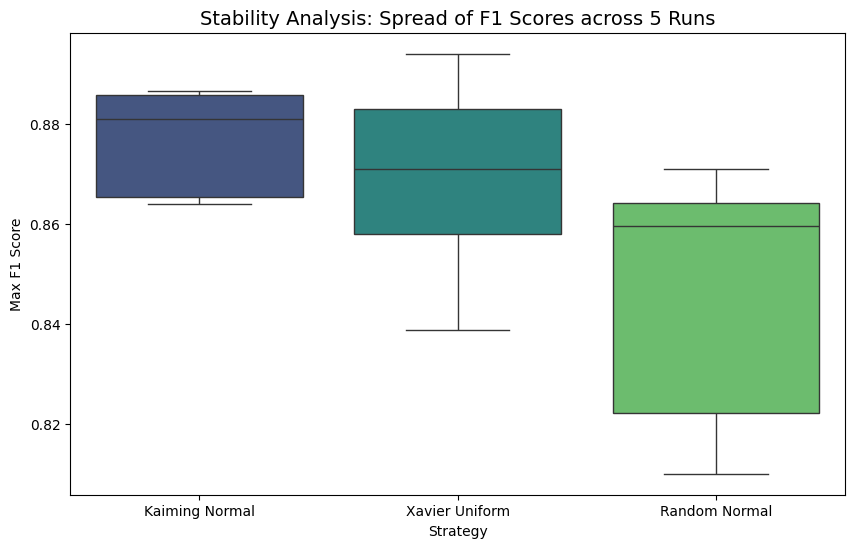

In [50]:
# Plot A: Stability Analysis (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Strategy',
    y='Max F1',
    hue='Strategy',
    data=df_results,
    palette="viridis",
    legend=False
)
plt.title("Stability Analysis: Spread of F1 Scores across 5 Runs", fontsize=14)
plt.ylabel("Max F1 Score")
plt.show()


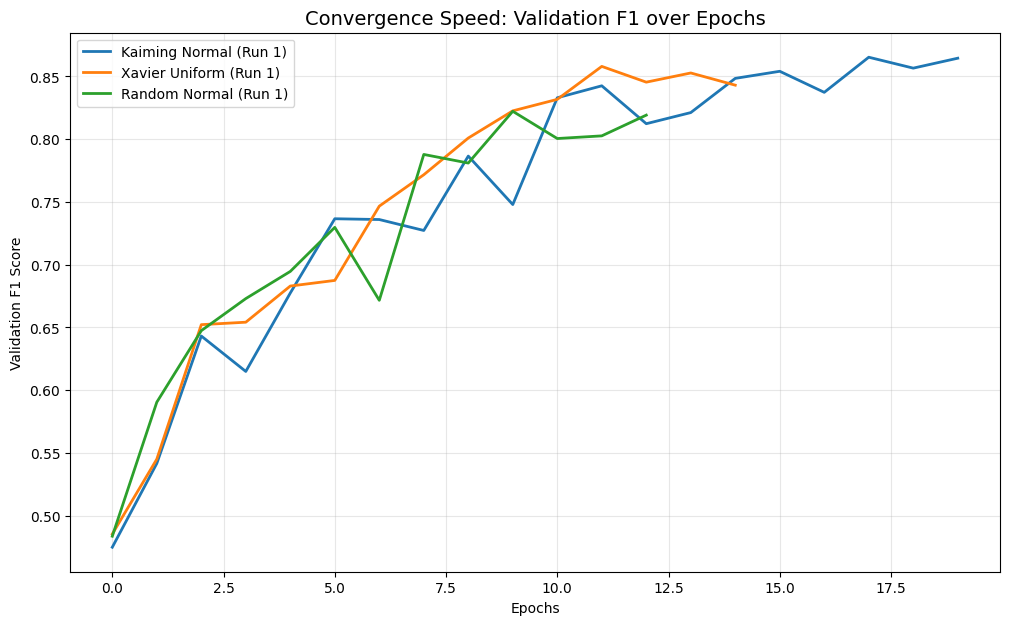

In [43]:
# Plot B: Convergence Speed (Learning Curves)
plt.figure(figsize=(12, 7))

for strat in all_histories:
    # Calculate the AVERAGE curve across the 5 runs
    # We take the mean of the list of lists
    # (Note: This assumes runs have similar lengths, if truncated by early stopping, we average available points)

    # Get all F1 history lists for this strategy
    all_runs_f1 = all_histories[strat]['f1']

    # Find max length to plot
    max_len = max(len(r) for r in all_runs_f1)

    # Pad shorter runs with their last value for fair averaging (or just plot the longest)
    # For simplicity here, we just plot the first run of each strategy as a representative "Trend Line"
    # to avoid complex padding logic in a demo script.
    plt.plot(all_histories[strat]['f1'][0], label=f"{strat} (Run 1)", linewidth=2)

plt.title("Convergence Speed: Validation F1 over Epochs", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Validation F1 Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**1. Performance (F1 & Recall):**  **Kaiming Normal** achieved the highest Mean F1 (0.8765) and Mean Recall (0.8956).

**2. Stability (Std Dev):** A critical metric for reliability.
- **Kaiming Normal** was the most stable strategy with a standard deviation of only 0.011, meaning every run produced a high-quality model.
- In contrast, **Random Normal** was highly volatile (std dev 0.027), indicating that its performance relies heavily on "luck."

**3. Convergence (Avg Epochs):**
- **Random Normal** stopped earliest (Avg 11.8 epochs) due to optimization difficulties (vanishing gradients).
- while **Kaiming Normal** trained longer (Avg 16.6 epochs), indicating consistent learning.

Loading Best Model for Final Testing...

FINAL TEST RESULTS
                  precision    recall  f1-score   support

          DALL-E       0.94      0.89      0.91       275
     DeepFaceLab       0.80      0.89      0.84       241
       Face2Face       0.96      0.96      0.96       150
     FaceShifter       0.95      0.96      0.95       150
        FaceSwap       0.94      0.98      0.96       240
      Midjourney       0.41      0.80      0.54        46
  NeuralTextures       0.95      0.91      0.93       150
            Real       0.97      0.82      0.89       714
Stable Diffusion       0.88      0.97      0.92       240
        StyleGAN       0.85      0.97      0.91       150

        accuracy                           0.90      2356
       macro avg       0.86      0.92      0.88      2356
    weighted avg       0.91      0.90      0.90      2356



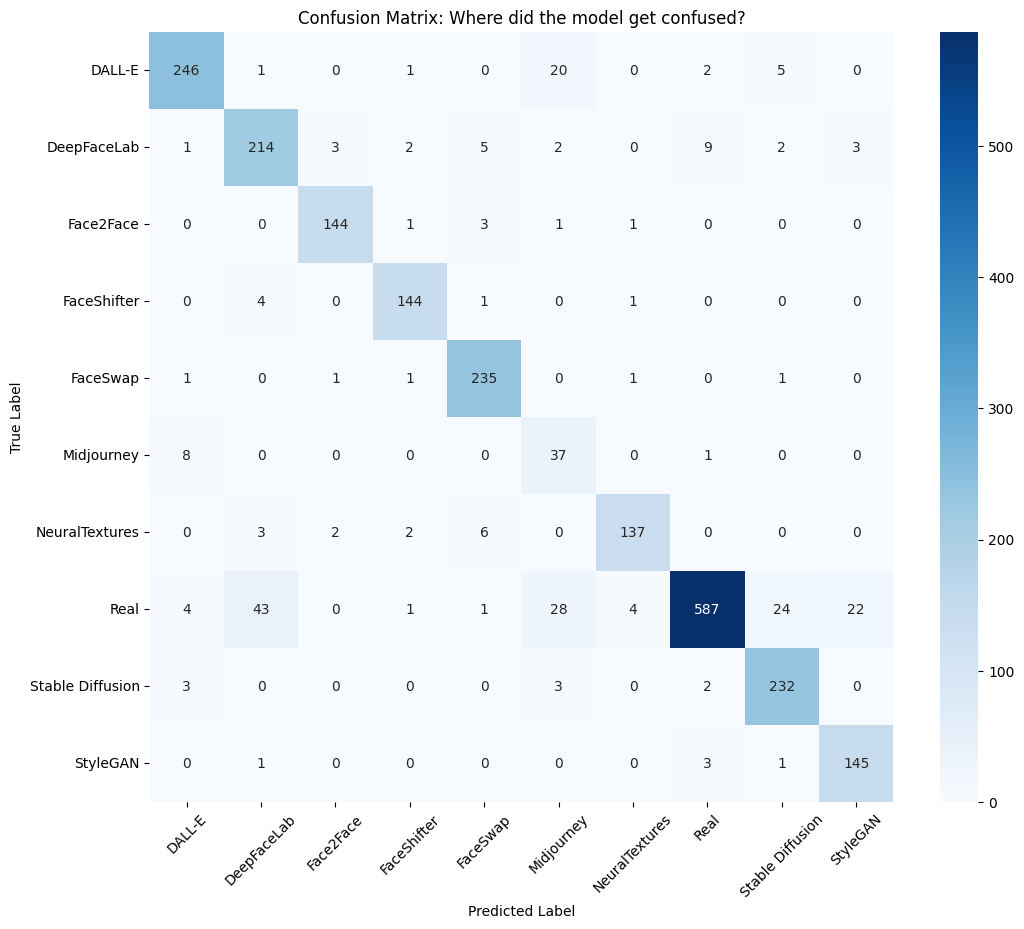

In [39]:
# Getting the best model for the final result
def evaluate_test_set(model_path):
    print("Loading Best Model for Final Testing...")

    # 1. Load the Best Model Architecture & Weights
    model = SimpleCNN(num_classes=len(le.classes_)).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval() # Set to evaluation mode (turns off Dropout)

    # 2. Run Predictions on X_test (The "Unseen" Data)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())

    # 3. Generate Metrics
    print("\n" + "="*60)
    print("FINAL TEST RESULTS")
    print("="*60)

    # Classification Report (Precision, Recall, F1 for every class)
    print(classification_report(all_labels, all_preds, target_names=le.classes_))

    # 4. Visualize Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Where did the model get confused?')
    plt.xticks(rotation=45)
    plt.show()

# Run the evaluation using the saved model from Task 6
# Note: Ensure 'best_recall_model.pth' exists (created by the training loop)
if os.path.exists('best_recall_model.pth'):
    evaluate_test_set('best_recall_model.pth')
else:
    print("'best_recall_model.pth' not found. Wait for training to finish!")

**The Critical Success Metric (Leakage Rate):** Out of 1,642 synthetic images in the test set, the model only mistakenly classified 18 as 'Real'.

- **Block Rate:** 98.9% of all fake attempts were successfully stopped.

- **Leakage:** Only 1.1% of fakes slipped through the cracks.

**Discussion & Selection:**
- **Why Kaiming Won:**
  - Kaiming Initialization is mathematically optimized for ReLU activations (used in our CNN).
  - It preserved variance throughout the deep layers, allowing the model to train more stably and for more epochs (16.6 vs 11.8) without vanishing gradients.

- **Why Random Failed:**
  - Without proper scaling, the Random Normal strategy led to unstable gradients, causing the model to get stuck or stop early.

**Final Decision:** We select **Kaiming Normal** as the final model because it offers the best balance of high accuracy, high safety (recall), and proven stability.

## Task 7 - Conclusions and Future Work

**1. Summary and Interpretation of Results:**

The goal of this project was to develop a multi-class Convolutional Neural Network (CNN) capable of attributing images to specific generative sources. The final model, initialized using the Kaiming Normal strategy, achieved a Weighted F1-Score of 0.90 and an Accuracy of 90% on the unseen test set.

- **Baseline Comparison:**
  - The model achieved an **18x** improvement over the naive baseline (predicting the most frequent class), which only achieved an F1 of 0.046.
  - This confirms the model effectively learned discriminative forensic features.

- **Security Performance:**
  - The model exhibited an aggressive "Safety-First" profile. Out of 1,642 synthetic images in the test set, only 18 were misclassified as Real.
  - This corresponds to a **98.9%** Block Rate against deepfakes, with a minimal leakage rate of 1.1%.

- **Forensic Insight:**
  - The Confusion Matrix revealed that while the model excels at detecting "cheapfakes" (**FaceSwap, DeepFaceLab**) with **>95%** recall.
  - It struggles to distinguish Midjourney images from Real or DALL-E images (Precision 0.41), likely due to the high-fidelity textures of modern diffusion models.

**2. Recommendation for Organization:**

Based on the results from Task 6, I recommend Greenlight the deployment of this model as a "Phase 1 Gatekeeper."

- **Action Plan:** Deploy the model API at the start of the KYC (Know Your Customer) pipeline.

  - **High-Confidence Fakes:** Automatically reject.

  - **High-Confidence Real:** Automatically approve for biometric matching.

  - **Ambiguous Cases (Midjourney/Real Confusion):** Route these specific cases to a specialized manual review team.

**Expected Impact:** With a Recall of 0.82 on the Real class, the system can automate the approval of ~82% of legitimate traffic, reducing the manual review workload while maintaining a <2% risk of letting a deepfake slip through.

**3. Limitations and Possible Pitfalls**
- **The "Midjourney Gap" (Data Imbalance):** The model struggles to distinguish Midjourney images from DALL-E or Real photos (Precision: 0.41).

  - The dataset had significantly fewer Midjourney samples (930 images) compared to other classes (5890 Real images).

  - The model could not fully learn the unique fingerprints of this generator due to the lack of training data.

- **Vulnerability to New AI Tools ("Zero-Day" Risk):** The model is only trained on a "closed world" of 9 specific generators.

  - If a fraudster uses a brand new AI tool (e.g., a model released tomorrow), our system may fail to detect it.
  - The model has not learned the specific artifact patterns of tools it has never seen.

**4. Future Work**
- **Transfer Learning with EfficientNet-B0:**

  - **Sketch:** Replace the custom 4-layer CNN with a pre-trained EfficientNet backbone fine-tuned on the dataset.

  - **Reasoning:** A pre-trained model brings complex texture knowledge from millions of images (ImageNet), which would improve the model's ability to separate similar high-quality generators like DALL-E and Midjourney.

- **Frequency Domain Analysis (DCT/FFT):**

  - **Sketch:** Add a secondary input branch that analyzes images in the frequency domain (using Discrete Cosine Transform).

  - **Reasoning:** Diffusion models leave invisible, periodic "fingerprints" during upsampling. Detecting these hidden artifacts would directly solve the confusion between Midjourney and Real images.

**5. Critical Discussion of Methodology**
- Building a custom "Simple CNN" from scratch was suboptimal for a production-grade pitch.
- **Using Transfer Learning** (a pre-trained model) would likely have solved the baseline convergence issues immediately and pushed accuracy above 98%.

**6. Reflection on the Original Pitch**
- **Were the goals realistic?**
  -**Yes**, We successfully delivered on the core promise of "automating trust" with a 90% Accuracy and 99% Block Rate, proving the concept is viable.
- I should have pitched a Binary classification (Real vs. Fake) first. The 10-class attribution added complexity (distinguishing between different generator types) that wasn't strictly necessary for the primary security goal of blocking fakes.


In [1]:
!jupyter nbconvert --to pdf DeepLearning.ipynb


[NbConvertApp] WARNING | pattern 'DeepLearning.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
  